<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Thedin-Bandara/thedin_jumperDep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.stattools import adfuller

##Loading Data

In [ ]:
# Specify the file path
!ls -l $file_path
# Load preprocessed data from Excel file
file_path = 'preprocessed_data_new.xlsx'
data = pd.read_excel(file_path)

total 3588
-rw-r--r-- 1 root root 3667660 Feb 26 03:57 preprocessed_data_new.xlsx
drwxr-xr-x 1 root root    4096 Feb 22 14:24 sample_data


##EDA(Explonatory Data Analysis)

In [ ]:
# Define a mapping of sub-departments to main departments
sub_dept_to_main_dept = {
    'Jumper Team': [sub_dept for sub_dept in data['Department'] if sub_dept.startswith('Jumper Team')],
}

# Map each sub-department to its main department
main_dept_for_sub_dept = {}
for main_dept, sub_depts in sub_dept_to_main_dept.items():
    for sub_dept in sub_depts:
        main_dept_for_sub_dept[sub_dept] = main_dept

# Add a new column indicating the main department for each row
data['MainDepartment'] = data['Department'].map(main_dept_for_sub_dept)

# Summarize total absence by main department
total_absence_by_main_dept = data.groupby(['LeaveYear','LeaveMonth','MainDepartment']).size().reset_index(name='totalAbsence')
print(total_absence_by_main_dept)


    LeaveYear  LeaveMonth MainDepartment  totalAbsence
0        2021          12    Jumper Team           111
1        2022           1    Jumper Team            91
2        2022           2    Jumper Team           131
3        2022           3    Jumper Team           188
4        2022           4    Jumper Team           120
5        2022           5    Jumper Team           189
6        2022           6    Jumper Team           151
7        2022           7    Jumper Team           114
8        2022           8    Jumper Team           135
9        2022           9    Jumper Team           131
10       2022          10    Jumper Team           142
11       2022          11    Jumper Team           136
12       2022          12    Jumper Team            96
13       2023           1    Jumper Team           102
14       2023           2    Jumper Team            81
15       2023           3    Jumper Team           107
16       2023           4    Jumper Team            18
17       2

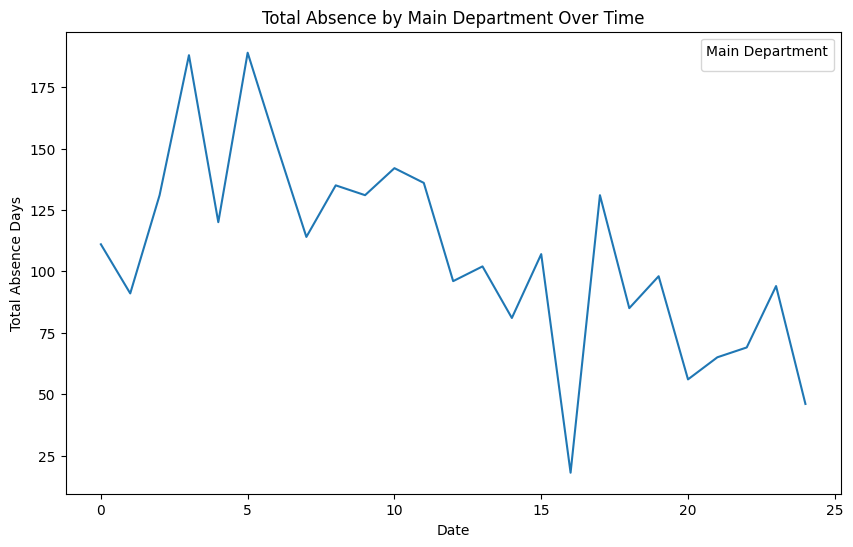

In [ ]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(total_absence_by_main_dept['totalAbsence'])
plt.title('Total Absence by Main Department Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence Days')
plt.legend(title='Main Department')
plt.show()

ADF Test

In [ ]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
adf_test(total_absence_by_main_dept['totalAbsence'])

ADF Statistic: -1.2660295708242042
p-value: 0.6445670445764196
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


##Train-Test Split

In [ ]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.8)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]

##Model Creation

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           totalAbsence   No. Observations:                   20
Model:                 ARIMA(4, 2, 2)   Log Likelihood                 -92.032
Date:                Mon, 26 Feb 2024   AIC                            198.063
Time:                        03:58:59   BIC                            204.296
Sample:                             0   HQIC                           198.923
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5804      0.901     -1.755      0.079      -3.346       0.185
ar.L2         -0.6216      1.083     -0.574      0.566      -2.744       1.501
ar.L3          0.2871      1.272      0.226      0.8

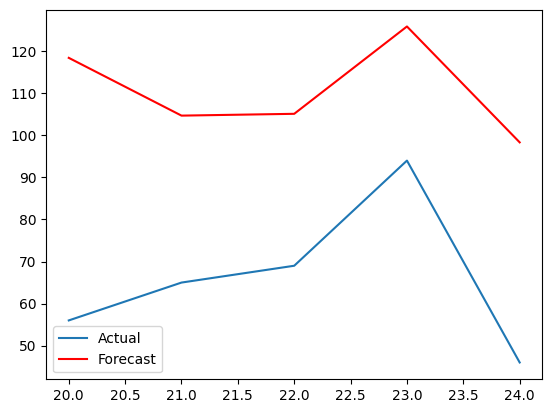

In [ ]:
# # Fit ARIMA model for each main department
model = ARIMA(train, order=(4,2,2))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))
print(forecast)

mse = mean_squared_error(test, forecast)
print("MSE : ", mse)

rsme = np.sqrt(mse)
print("RSME : ", rsme)

plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.show()